# 第11章 时间序列 Time Series

时间序列（time series）数据是⼀种重要的结构化数据形式，应
⽤于多个领域，包括⾦融学、经济学、⽣态学、神经科学、物理
学等。在多个时间点观察或测量到的任何事物都可以形成⼀段时
间序列。很多时间序列是固定频率的，也就是说，数据点是根据
某种规律定期出现的（⽐如每15秒、每5分钟、每⽉出现⼀
次）。时间序列也可以是不定期的，没有固定的时间单位或单位
之间的偏移量。时间序列数据的意义取决于具体的应⽤场景，主
要有以下⼏种：

* 时间戳（timestamp），特定的时刻
* 固定时期（period），如2007年1⽉或2010年全年。
* 时间间隔（interval），由起始和结束时间戳表示。时期
（period）可以被看做间隔（interval）的特例。
* 实验或过程时间，每个时间点都是相对于特定起始时间的⼀
个度量。例如，从放⼊烤箱时起，每秒钟饼⼲的直径。

本章主要讲解前3种时间序列。许多技术都可⽤于处理实验型时
间序列，其索引可能是⼀个整数或浮点数（表示从实验开始算起
已经过去的时间）。最简单也最常⻅的时间序列都是⽤时间戳进
⾏索引的。

pandas提供了许多内置的时间序列处理⼯具和数据算法。因
此，你可以⾼效处理⾮常⼤的时间序列，轻松地进⾏切⽚/切
块、聚合、对定期/不定期的时间序列进⾏重采样等。有些⼯具
特别适合⾦融和经济应⽤，你当然也可以⽤它们来分析服务器⽇
志数据。

In [180]:
import numpy as np
import pandas as pd
np.random.seed(12345)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
np.set_printoptions(precision=4, suppress=True)

## 11.1 ⽇期和时间数据类型及⼯具 Date and Time Data Types and Tools

Python标准库包含⽤于⽇期（date）和时间（time）数据的数据
类型，⽽且还有⽇历⽅⾯的功能。我们主要会⽤到datetime、
time以及calendar模块。 datetime.datetime（也可以简写为
datetime）是⽤得最多的数据类型：

In [2]:
from datetime import datetime
now = datetime.now()
now

datetime.datetime(2019, 5, 26, 10, 43, 38, 686101)

In [3]:
now.year, now.month, now.day

(2019, 5, 26)

datetime以毫秒形式存储⽇期和时间。 timedelta表示两个
datetime对象之间的时间差：

In [4]:
delta = datetime(2011, 1, 7) - datetime(2008, 6, 24, 8, 15)
delta

datetime.timedelta(926, 56700)

In [5]:
delta.days

926

In [6]:
delta.seconds

56700

可以给datetime对象加上（或减去）⼀个或多个timedelta，这样
会产⽣⼀个新对象：

In [8]:
from datetime import timedelta
start = datetime(2011, 1, 7)
start + timedelta(12)

datetime.datetime(2011, 1, 19, 0, 0)

In [9]:
start - 2 * timedelta(12)

datetime.datetime(2010, 12, 14, 0, 0)

### 字符串和datetime的相互转换 Converting Between String and Datetime

利⽤str或strftime⽅法（传⼊⼀个格式化字符串）， datetime对象
和pandas的Timestamp对象（稍后就会介绍）可以被格式化为字
符串

In [13]:
stamp = datetime(2012, 1, 3)
str(stamp)

'2012-01-03 00:00:00'

In [14]:
stamp.strftime('%Y-%m-%d')

'2012-01-03'

datetime.strptime可以⽤这些格式化编码将字符串转换为⽇期：

In [16]:
value = '2012-01-03'
datetime.strptime(value, '%Y-%m-%d')

datetime.datetime(2012, 1, 3, 0, 0)

In [17]:
datestrs = ['7/6/2011', '8/6/2011']

In [18]:
[datetime.strptime(x, '%m/%d/%Y') for x in datestrs]

[datetime.datetime(2011, 7, 6, 0, 0), datetime.datetime(2011, 8, 6, 0, 0)]

datetime.strptime是通过已知格式进⾏⽇期解析的最佳⽅式。但
是每次都要编写格式定义是很麻烦的事情，尤其是对于⼀些常⻅
的⽇期格式。这种情况下，你可以⽤dateutil这个第三⽅包中的
parser.parse⽅法（pandas中已经⾃动安装好了）：

In [20]:
from dateutil.parser import parse
parse('2011-01-03')

datetime.datetime(2011, 1, 3, 0, 0)

dateutil可以解析⼏乎所有⼈类能够理解的⽇期表示形式：

In [22]:
parse('Jan 31, 1997 10:45 PM')

datetime.datetime(1997, 1, 31, 22, 45)

在国际通⽤的格式中，⽇出现在⽉的前⾯很普遍，传⼊
dayfirst=True即可解决这个问题

In [24]:
parse('6/12/2011', dayfirst=True)

datetime.datetime(2011, 12, 6, 0, 0)

pandas通常是⽤于处理成组⽇期的，不管这些⽇期是
DataFrame的轴索引还是列。 to_datetime⽅法可以解析多种不同
的⽇期表示形式。对标准⽇期格式（如ISO8601）的解析⾮常
快：

In [25]:
datestrs = ['2011-07-06 12:00:00', '2011-08-06 00:00:00']
pd.to_datetime(datestrs)

DatetimeIndex(['2011-07-06 12:00:00', '2011-08-06 00:00:00'], dtype='datetime64[ns]', freq=None)

它还可以处理缺失值（None、空字符串等）：

In [26]:
idx = pd.to_datetime(datestrs + [None])
idx

DatetimeIndex(['2011-07-06 12:00:00', '2011-08-06 00:00:00', 'NaT'], dtype='datetime64[ns]', freq=None)

In [27]:
idx[2]

NaT

In [28]:
pd.isnull(idx)

array([False, False,  True])

NaT（Not a Time）是pandas中时间戳数据的null值。

datetime对象还有⼀些特定于当前环境（位于不同国家或使⽤不
同语⾔的系统）的格式化选项。例如，德语或法语系统所⽤的
份简写就与英语系统所⽤的不同。

## 11.2 时间序列基础 Time Series Basics

pandas最基本的时间序列类型就是以时间戳（通常以Python字
符串或datatime对象表示）为索引的Series：

In [31]:
from datetime import datetime
dates = [datetime(2011, 1, 2), datetime(2011, 1, 5),
         datetime(2011, 1, 7), datetime(2011, 1, 8),
         datetime(2011, 1, 10), datetime(2011, 1, 12)]
ts = pd.Series(np.random.randn(6), index=dates)
ts

2011-01-02   -0.204708
2011-01-05    0.478943
2011-01-07   -0.519439
2011-01-08   -0.555730
2011-01-10    1.965781
2011-01-12    1.393406
dtype: float64

这些datetime对象实际上是被放在⼀个DatetimeIndex中的：

In [32]:
ts.index

DatetimeIndex(['2011-01-02', '2011-01-05', '2011-01-07', '2011-01-08',
               '2011-01-10', '2011-01-12'],
              dtype='datetime64[ns]', freq=None)

跟其他Series⼀样，不同索引的时间序列之间的算术运算会⾃动
按⽇期对⻬：

In [34]:
ts + ts[::2]

2011-01-02   -0.409415
2011-01-05         NaN
2011-01-07   -1.038877
2011-01-08         NaN
2011-01-10    3.931561
2011-01-12         NaN
dtype: float64

ts[::2] 是每隔两个取⼀个。
pandas⽤NumPy的datetime64数据类型以纳秒形式存储时间
戳

In [35]:
ts.index.dtype

dtype('<M8[ns]')

DatetimeIndex中的各个标量值是pandas的Timestamp对象：

In [37]:
stamp = ts.index[0]
stamp

Timestamp('2011-01-02 00:00:00')

只要有需要， TimeStamp可以随时⾃动转换为datetime对象。此
外，它还可以存储频率信息（如果有的话），且知道如何执⾏时
区转换以及其他操作。稍后将对此进⾏详细讲解。

### 索引、选取、⼦集构造 Indexing, Selection, Subsetting

当你根据标签索引选取数据时，时间序列和其它的
pandas.Series很像

In [40]:
stamp = ts.index[2]
ts[stamp]

-0.5194387150567381

还有⼀种更为⽅便的⽤法：传⼊⼀个可以被解释为⽇期的字符
串

In [41]:
ts['1/10/2011']

1.9657805725027142

In [43]:
ts['20110110']

1.9657805725027142

对于较⻓的时间序列，只需传⼊“年”或“年⽉”即可轻松选取数据
的切⽚：

In [44]:
longer_ts = pd.Series(np.random.randn(1000),
                      index=pd.date_range('1/1/2000', periods=1000))
longer_ts
longer_ts['2001']

2001-01-01    1.599534
2001-01-02    0.474071
2001-01-03    0.151326
2001-01-04   -0.542173
2001-01-05   -0.475496
2001-01-06    0.106403
2001-01-07   -1.308228
2001-01-08    2.173185
2001-01-09    0.564561
2001-01-10   -0.190481
                ...   
2001-12-22    0.000369
2001-12-23    0.900885
2001-12-24   -0.454869
2001-12-25   -0.864547
2001-12-26    1.129120
2001-12-27    0.057874
2001-12-28   -0.433739
2001-12-29    0.092698
2001-12-30   -1.397820
2001-12-31    1.457823
Freq: D, Length: 365, dtype: float64

这⾥，字符串“2001”被解释成年，并根据它选取时间区间。指定
⽉也同样奏效

In [45]:
longer_ts['2001-05']

2001-05-01   -0.622547
2001-05-02    0.936289
2001-05-03    0.750018
2001-05-04   -0.056715
2001-05-05    2.300675
2001-05-06    0.569497
2001-05-07    1.489410
2001-05-08    1.264250
2001-05-09   -0.761837
2001-05-10   -0.331617
                ...   
2001-05-22    0.503699
2001-05-23   -1.387874
2001-05-24    0.204851
2001-05-25    0.603705
2001-05-26    0.545680
2001-05-27    0.235477
2001-05-28    0.111835
2001-05-29   -1.251504
2001-05-30   -2.949343
2001-05-31    0.634634
Freq: D, Length: 31, dtype: float64

datetime对象也可以进⾏切⽚：

In [46]:
ts[datetime(2011, 1, 7):]

2011-01-07   -0.519439
2011-01-08   -0.555730
2011-01-10    1.965781
2011-01-12    1.393406
dtype: float64

由于⼤部分时间序列数据都是按照时间先后排序的，因此你也可
以⽤不存在于该时间序列中的时间戳对其进⾏切⽚（即范围查
询）：

In [47]:
ts

2011-01-02   -0.204708
2011-01-05    0.478943
2011-01-07   -0.519439
2011-01-08   -0.555730
2011-01-10    1.965781
2011-01-12    1.393406
dtype: float64

In [48]:
ts['1/6/2011':'1/11/2011']

2011-01-07   -0.519439
2011-01-08   -0.555730
2011-01-10    1.965781
dtype: float64

跟之前⼀样，你可以传⼊字符串⽇期、 datetime或Timestamp。
注意，这样切⽚所产⽣的是源时间序列的视图，跟NumPy数组
的切⽚运算是⼀样的。

这意味着，没有数据被复制，对切⽚进⾏修改会反映到原始数据
上。
此外，还有⼀个等价的实例⽅法也可以截取两个⽇期之间
TimeSeries

In [50]:
ts.truncate(after='1/9/2011')

2011-01-02   -0.204708
2011-01-05    0.478943
2011-01-07   -0.519439
2011-01-08   -0.555730
dtype: float64

⾯这些操作对DataFrame也有效。例如，对DataFrame的⾏进⾏
索引

In [51]:
dates = pd.date_range('1/1/2000', periods=100, freq='W-WED')
long_df = pd.DataFrame(np.random.randn(100, 4),
                       index=dates,
                       columns=['Colorado', 'Texas',
                                'New York', 'Ohio'])
long_df.loc['5-2001']

,Colorado,Texas,New York,Ohio
2001-05-02,-0.006045,0.490094,-0.277186,-0.707213
2001-05-09,-0.560107,2.735527,0.927335,1.513906
2001-05-16,0.538600,1.273768,0.667876,-0.969206
2001-05-23,1.676091,-0.817649,0.050188,1.951312
2001-05-30,3.260383,0.963301,1.201206,-1.852001


### 带有重复索引的时间序列 Time Series with Duplicate Indices

在某些应⽤场景中，可能会存在多个观测数据落在同⼀个时间点
上的情况。下⾯就是⼀个例⼦：

In [52]:
dates = pd.DatetimeIndex(['1/1/2000', '1/2/2000', '1/2/2000',
                          '1/2/2000', '1/3/2000'])
dup_ts = pd.Series(np.arange(5), index=dates)
dup_ts

2000-01-01    0
2000-01-02    1
2000-01-02    2
2000-01-02    3
2000-01-03    4
dtype: int32

通过检查索引的is_unique属性，我们就可以知道它是不是唯⼀
的：

In [53]:
dup_ts.index.is_unique

False

对这个时间序列进⾏索引，要么产⽣标量值，要么产⽣切⽚，具
体要看所选的时间点是否重复：

In [54]:
dup_ts['1/3/2000']  # not duplicated

4

In [55]:
dup_ts['1/2/2000']  # duplicated

2000-01-02    1
2000-01-02    2
2000-01-02    3
dtype: int32

假设你想要对具有⾮唯⼀时间戳的数据进⾏聚合。⼀个办法是使
⽤groupby，并传⼊level=0：

In [56]:
grouped = dup_ts.groupby(level=0)

In [57]:
grouped.mean()

2000-01-01    0
2000-01-02    2
2000-01-03    4
dtype: int32

In [58]:
grouped.count()

2000-01-01    1
2000-01-02    3
2000-01-03    1
dtype: int64

 ### 11.3 ⽇期的范围、频率以及移动    Date Ranges, Frequencies, and Shifting

pandas中的原⽣时间序列⼀般被认为是不规则的，也就是说，
它们没有固定的频率。对于⼤部分应⽤程序⽽⾔，这是⽆所谓
的。但是，它常常需要以某种相对固定的频率进⾏分析，⽐如每
⽇、每⽉、每15分钟等（这样⾃然会在时间序列中引⼊缺失
值）。幸运的是， pandas有⼀整套标准时间序列频率以及⽤于
重采样、频率推断、⽣成固定频率⽇期范围的⼯具。例如，我们
可以将之前那个时间序列转换为⼀个具有固定频率（每⽇）的时
间序列，只需调⽤resample即可：

In [60]:
ts

2011-01-02   -0.204708
2011-01-05    0.478943
2011-01-07   -0.519439
2011-01-08   -0.555730
2011-01-10    1.965781
2011-01-12    1.393406
dtype: float64

In [61]:
resampler = ts.resample('D')

字符串“D”是每天的意思。
频率的转换（或重采样）是⼀个⽐较⼤的主题，稍后将专⻔⽤⼀
节来进⾏讨论（11.6⼩节）。这⾥，我将告诉你如何使⽤基本的
频率和它的倍数

### ⽣成⽇期范围 Generating Date Ranges

虽然我之前⽤的时候没有明说，但你可能已经猜到
pandas.date_range可⽤于根据指定的频率⽣成指定⻓度的
DatetimeIndex

In [62]:
index = pd.date_range('2012-04-01', '2012-06-01')
index

DatetimeIndex(['2012-04-01', '2012-04-02', '2012-04-03', '2012-04-04',
               '2012-04-05', '2012-04-06', '2012-04-07', '2012-04-08',
               '2012-04-09', '2012-04-10', '2012-04-11', '2012-04-12',
               '2012-04-13', '2012-04-14', '2012-04-15', '2012-04-16',
               '2012-04-17', '2012-04-18', '2012-04-19', '2012-04-20',
               '2012-04-21', '2012-04-22', '2012-04-23', '2012-04-24',
               '2012-04-25', '2012-04-26', '2012-04-27', '2012-04-28',
               '2012-04-29', '2012-04-30', '2012-05-01', '2012-05-02',
               '2012-05-03', '2012-05-04', '2012-05-05', '2012-05-06',
               '2012-05-07', '2012-05-08', '2012-05-09', '2012-05-10',
               '2012-05-11', '2012-05-12', '2012-05-13', '2012-05-14',
               '2012-05-15', '2012-05-16', '2012-05-17', '2012-05-18',
               '2012-05-19', '2012-05-20', '2012-05-21', '2012-05-22',
               '2012-05-23', '2012-05-24', '2012-05-25', '2012-05-26',
      

默认情况下， date_range会产⽣按天计算的时间点。如果只传⼊
起始或结束⽇期，那就还得传⼊⼀个表示⼀段时间的数字：

In [63]:
pd.date_range(start='2012-04-01', periods=20)

DatetimeIndex(['2012-04-01', '2012-04-02', '2012-04-03', '2012-04-04',
               '2012-04-05', '2012-04-06', '2012-04-07', '2012-04-08',
               '2012-04-09', '2012-04-10', '2012-04-11', '2012-04-12',
               '2012-04-13', '2012-04-14', '2012-04-15', '2012-04-16',
               '2012-04-17', '2012-04-18', '2012-04-19', '2012-04-20'],
              dtype='datetime64[ns]', freq='D')

In [64]:
pd.date_range(end='2012-06-01', periods=20)

DatetimeIndex(['2012-05-13', '2012-05-14', '2012-05-15', '2012-05-16',
               '2012-05-17', '2012-05-18', '2012-05-19', '2012-05-20',
               '2012-05-21', '2012-05-22', '2012-05-23', '2012-05-24',
               '2012-05-25', '2012-05-26', '2012-05-27', '2012-05-28',
               '2012-05-29', '2012-05-30', '2012-05-31', '2012-06-01'],
              dtype='datetime64[ns]', freq='D')

起始和结束⽇期定义了⽇期索引的严格边界。例如，如果你想要
⽣成⼀个由每⽉最后⼀个⼯作⽇组成的⽇期索引，可以传
⼊"BM"频率（表示business end of month，表11-4是频率列
432表），这样就只会包含时间间隔内（或刚好在边界上的）符合频
率要求的⽇期：

In [65]:
pd.date_range('2000-01-01', '2000-12-01', freq='BM')

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-28',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-29', '2000-10-31', '2000-11-30'],
              dtype='datetime64[ns]', freq='BM')

date_range默认会保留起始和结束时间戳的时间信息（如果有的
话）：

In [66]:
pd.date_range('2012-05-02 12:56:31', periods=5)

DatetimeIndex(['2012-05-02 12:56:31', '2012-05-03 12:56:31',
               '2012-05-04 12:56:31', '2012-05-05 12:56:31',
               '2012-05-06 12:56:31'],
              dtype='datetime64[ns]', freq='D')

有时，虽然起始和结束⽇期带有时间信息，但你希望产⽣⼀组被
规范化（normalize）到午夜的时间戳。 normalize选项即可实现
该功能：

In [67]:
pd.date_range('2012-05-02 12:56:31', periods=5, normalize=True)

DatetimeIndex(['2012-05-02', '2012-05-03', '2012-05-04', '2012-05-05',
               '2012-05-06'],
              dtype='datetime64[ns]', freq='D')

### 频率和⽇期偏移量 Frequencies and Date Offsets

pandas中的频率是由⼀个基础频率（base frequency）和⼀个乘
数组成的。基础频率通常以⼀个字符串别名表示，⽐如"M"表示
每⽉， "H"表示每⼩时。对于每个基础频率，都有⼀个被称为⽇
期偏移量（date offset）的对象与之对应。例如，按⼩时计算的
频率可以⽤Hour类表示：

In [68]:
from pandas.tseries.offsets import Hour, Minute
hour = Hour()
hour

<Hour>

传⼊⼀个整数即可定义偏移量的倍数：

In [69]:
four_hours = Hour(4)
four_hours

<4 * Hours>

⼀般来说，⽆需明确创建这样的对象，只需使⽤诸
如"H"或"4H"这样的字符串别名即可。在基础频率前⾯放上⼀个
整数即可创建倍数：

In [70]:
pd.date_range('2000-01-01', '2000-01-03 23:59', freq='4h')

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 04:00:00',
               '2000-01-01 08:00:00', '2000-01-01 12:00:00',
               '2000-01-01 16:00:00', '2000-01-01 20:00:00',
               '2000-01-02 00:00:00', '2000-01-02 04:00:00',
               '2000-01-02 08:00:00', '2000-01-02 12:00:00',
               '2000-01-02 16:00:00', '2000-01-02 20:00:00',
               '2000-01-03 00:00:00', '2000-01-03 04:00:00',
               '2000-01-03 08:00:00', '2000-01-03 12:00:00',
               '2000-01-03 16:00:00', '2000-01-03 20:00:00'],
              dtype='datetime64[ns]', freq='4H')

⼤部分偏移量对象都可通过加法进⾏连接：

In [71]:
Hour(2) + Minute(30)

<150 * Minutes>

同理，你也可以传⼊频率字符串（如"2h30min"），这种字符串
可以被⾼效地解析为等效的表达式：

In [72]:
pd.date_range('2000-01-01', periods=10, freq='1h30min')

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 01:30:00',
               '2000-01-01 03:00:00', '2000-01-01 04:30:00',
               '2000-01-01 06:00:00', '2000-01-01 07:30:00',
               '2000-01-01 09:00:00', '2000-01-01 10:30:00',
               '2000-01-01 12:00:00', '2000-01-01 13:30:00'],
              dtype='datetime64[ns]', freq='90T')

有些频率所描述的时间点并不是均匀分隔的。例如， "M"（⽇历
⽉末）和"BM"（每⽉最后⼀个⼯作⽇）就取决于每⽉的天数，对
于后者，还要考虑⽉末是不是周末。由于没有更好的术语，我将
这些称为锚点偏移量（anchored offset）。

###  WOM⽇期 Week of month dates

WOM（Week Of Month）是⼀种⾮常实⽤的频率类，它以WOM
开头。它使你能获得诸如“每⽉第3个星期五”之类的⽇期

In [73]:
rng = pd.date_range('2012-01-01', '2012-09-01', freq='WOM-3FRI')
list(rng)

[Timestamp('2012-01-20 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-02-17 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-03-16 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-04-20 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-05-18 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-06-15 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-07-20 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-08-17 00:00:00', freq='WOM-3FRI')]

### 移动（超前和滞后）数据  Shifting (Leading and Lagging) Data

移动（shifting）指的是沿着时间轴将数据前移或后移。 Series和
DataFrame都有⼀个shift⽅法⽤于执⾏单纯的前移或后移操作，
保持索引不变：

In [74]:
ts = pd.Series(np.random.randn(4),
               index=pd.date_range('1/1/2000', periods=4, freq='M'))
ts

2000-01-31   -0.066748
2000-02-29    0.838639
2000-03-31   -0.117388
2000-04-30   -0.517795
Freq: M, dtype: float64

In [75]:
ts.shift(2)

2000-01-31         NaN
2000-02-29         NaN
2000-03-31   -0.066748
2000-04-30    0.838639
Freq: M, dtype: float64

In [76]:
ts.shift(-2)

2000-01-31   -0.117388
2000-02-29   -0.517795
2000-03-31         NaN
2000-04-30         NaN
Freq: M, dtype: float64

当我们这样进⾏移动时，就会在时间序列的前⾯或后⾯产⽣缺失
数据。

shift通常⽤于计算⼀个时间序列或多个时间序列（如DataFrame
的列）中的百分⽐变化。可以这样表达：

ts / ts.shift(1) - 1

由于单纯的移位操作不会修改索引，所以部分数据会被丢弃。因
此，如果频率已知，则可以将其传给shift以便实现对时间戳进⾏
位移⽽不是对数据进⾏简单位移：

In [77]:
ts.shift(2, freq='M')

2000-03-31   -0.066748
2000-04-30    0.838639
2000-05-31   -0.117388
2000-06-30   -0.517795
Freq: M, dtype: float64

这⾥还可以使⽤其他频率，于是你就能⾮常灵活地对数据进⾏超
前和滞后处理了：

In [78]:
ts.shift(3, freq='D')

2000-02-03   -0.066748
2000-03-03    0.838639
2000-04-03   -0.117388
2000-05-03   -0.517795
dtype: float64

In [79]:
ts.shift(1, freq='90T')

2000-01-31 01:30:00   -0.066748
2000-02-29 01:30:00    0.838639
2000-03-31 01:30:00   -0.117388
2000-04-30 01:30:00   -0.517795
Freq: M, dtype: float64

### 通过偏移量对⽇期进⾏位移 Shifting dates with offsets

pandas的⽇期偏移量还可以⽤在datetime或Timestamp对象上：

In [80]:
from pandas.tseries.offsets import Day, MonthEnd
now = datetime(2011, 11, 17)
now + 3 * Day()

Timestamp('2011-11-20 00:00:00')

如果加的是锚点偏移量（⽐如MonthEnd），第⼀次增量会将原
⽇期向前滚动到符合频率规则的下⼀个⽇期：

In [81]:
now + MonthEnd()

Timestamp('2011-11-30 00:00:00')

In [82]:
now + MonthEnd(2)

Timestamp('2011-12-31 00:00:00')

通过锚点偏移量的rollforward和rollback⽅法，可明确地将⽇期向
前或向后“滚动”：

In [83]:
offset = MonthEnd()

In [84]:
offset.rollforward(now)

Timestamp('2011-11-30 00:00:00')

In [85]:
offset.rollback(now)

Timestamp('2011-10-31 00:00:00')

⽇期偏移量还有⼀个巧妙的⽤法，即结合groupby使⽤这两个“滚
动”⽅法

In [86]:
ts = pd.Series(np.random.randn(20),
               index=pd.date_range('1/15/2000', periods=20, freq='4d'))
ts

2000-01-15   -0.116696
2000-01-19    2.389645
2000-01-23   -0.932454
2000-01-27   -0.229331
2000-01-31   -1.140330
2000-02-04    0.439920
2000-02-08   -0.823758
2000-02-12   -0.520930
2000-02-16    0.350282
2000-02-20    0.204395
2000-02-24    0.133445
2000-02-28    0.327905
2000-03-03    0.072153
2000-03-07    0.131678
2000-03-11   -1.297459
2000-03-15    0.997747
2000-03-19    0.870955
2000-03-23   -0.991253
2000-03-27    0.151699
2000-03-31    1.266151
Freq: 4D, dtype: float64

In [87]:
ts.groupby(offset.rollforward).mean()

2000-01-31   -0.005833
2000-02-29    0.015894
2000-03-31    0.150209
dtype: float64

当然，更简单、更快速地实现该功能的办法是使⽤
resample（11.6⼩节将对此进⾏详细介绍）：

In [88]:
ts.resample('M').mean()

2000-01-31   -0.005833
2000-02-29    0.015894
2000-03-31    0.150209
Freq: M, dtype: float64

##  11.4 时区处理Time Zone Handling

时间序列处理⼯作中最让⼈不爽的就是对时区的处理。许多⼈都
选择以协调世界时（UTC，它是格林尼治标准时间（Greenwich
Mean Time）的接替者，⽬前已经是国际标准了）来处理时间序
列。时区是以UTC偏移量的形式表示的。例如，夏令时期间，纽
约⽐UTC慢4⼩时，⽽在全年其他时间则⽐UTC慢5⼩时。
在Python中，时区信息来⾃第三⽅库pytz，它使Python可以使⽤
Olson数据库（汇编了世界时区信息）。这对历史数据⾮常重
要，这是因为由于各地政府的各种突发奇想，夏令时转变⽇期
（甚⾄UTC偏移量）已经发⽣过多次改变了。就拿美国来说，
DST转变时间⾃1900年以来就改变过多次！
有关pytz库的更多信息，请查阅其⽂档。就本书⽽⾔，由于
pandas包装了pytz的功能，因此你可以不⽤记忆其API，只要记
得时区的名称即可。时区名可以在shell中看到，也可以通过⽂档
查看：

In [89]:
import pytz
pytz.common_timezones[-5:]

['US/Eastern', 'US/Hawaii', 'US/Mountain', 'US/Pacific', 'UTC']

要从pytz中获取时区对象，使⽤pytz.timezone即可：

In [90]:
tz = pytz.timezone('America/New_York')
tz

<DstTzInfo 'America/New_York' LMT-1 day, 19:04:00 STD>

pandas中的⽅法既可以接受时区名也可以接受这些对象。

### 时区本地化和转换 Time Zone Localization and Conversion

默认情况下， pandas中的时间序列是单纯的（naive）时区。看
看下⾯这个时间序列：

In [91]:
rng = pd.date_range('3/9/2012 9:30', periods=6, freq='D')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts

2012-03-09 09:30:00   -0.202469
2012-03-10 09:30:00    0.050718
2012-03-11 09:30:00    0.639869
2012-03-12 09:30:00    0.597594
2012-03-13 09:30:00   -0.797246
2012-03-14 09:30:00    0.472879
Freq: D, dtype: float64

其索引的tz字段为None：

In [92]:
print(ts.index.tz)

None


可以⽤时区集⽣成⽇期范围：

In [93]:
pd.date_range('3/9/2012 9:30', periods=10, freq='D', tz='UTC')

DatetimeIndex(['2012-03-09 09:30:00+00:00', '2012-03-10 09:30:00+00:00',
               '2012-03-11 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00',
               '2012-03-15 09:30:00+00:00', '2012-03-16 09:30:00+00:00',
               '2012-03-17 09:30:00+00:00', '2012-03-18 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='D')

从单纯到本地化的转换是通过tz_localize⽅法处理的：

In [94]:
ts

2012-03-09 09:30:00   -0.202469
2012-03-10 09:30:00    0.050718
2012-03-11 09:30:00    0.639869
2012-03-12 09:30:00    0.597594
2012-03-13 09:30:00   -0.797246
2012-03-14 09:30:00    0.472879
Freq: D, dtype: float64

In [95]:
ts_utc = ts.tz_localize('UTC')
ts_utc

2012-03-09 09:30:00+00:00   -0.202469
2012-03-10 09:30:00+00:00    0.050718
2012-03-11 09:30:00+00:00    0.639869
2012-03-12 09:30:00+00:00    0.597594
2012-03-13 09:30:00+00:00   -0.797246
2012-03-14 09:30:00+00:00    0.472879
Freq: D, dtype: float64

In [96]:
ts_utc.index

DatetimeIndex(['2012-03-09 09:30:00+00:00', '2012-03-10 09:30:00+00:00',
               '2012-03-11 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='D')

⼀旦时间序列被本地化到某个特定时区，就可以⽤tz_convert将
其转换到别的时区了：

In [97]:
ts_utc.tz_convert('America/New_York')

2012-03-09 04:30:00-05:00   -0.202469
2012-03-10 04:30:00-05:00    0.050718
2012-03-11 05:30:00-04:00    0.639869
2012-03-12 05:30:00-04:00    0.597594
2012-03-13 05:30:00-04:00   -0.797246
2012-03-14 05:30:00-04:00    0.472879
Freq: D, dtype: float64

对于上⾯这种时间序列（它跨越了美国东部时区的夏令时转变
期），我们可以将其本地化到EST，然后转换为UTC或柏林时
间：

In [98]:
ts_eastern = ts.tz_localize('America/New_York')
ts_eastern.tz_convert('UTC')

2012-03-09 14:30:00+00:00   -0.202469
2012-03-10 14:30:00+00:00    0.050718
2012-03-11 13:30:00+00:00    0.639869
2012-03-12 13:30:00+00:00    0.597594
2012-03-13 13:30:00+00:00   -0.797246
2012-03-14 13:30:00+00:00    0.472879
Freq: D, dtype: float64

In [99]:
ts_eastern.tz_convert('Europe/Berlin')

2012-03-09 15:30:00+01:00   -0.202469
2012-03-10 15:30:00+01:00    0.050718
2012-03-11 14:30:00+01:00    0.639869
2012-03-12 14:30:00+01:00    0.597594
2012-03-13 14:30:00+01:00   -0.797246
2012-03-14 14:30:00+01:00    0.472879
Freq: D, dtype: float64

tz_localize和tz_convert也是DatetimeIndex的实例⽅法：

In [100]:
ts.index.tz_localize('Asia/Shanghai')

DatetimeIndex(['2012-03-09 09:30:00+08:00', '2012-03-10 09:30:00+08:00',
               '2012-03-11 09:30:00+08:00', '2012-03-12 09:30:00+08:00',
               '2012-03-13 09:30:00+08:00', '2012-03-14 09:30:00+08:00'],
              dtype='datetime64[ns, Asia/Shanghai]', freq='D')

### 操作时区意识型Timestamp对象 Operations with Time Zone−Aware Timestamp Objects

跟时间序列和⽇期范围差不多，独⽴的Timestamp对象也能被从
单纯型（naive）本地化为时区意识型（time zone-aware），并
从⼀个时区转换到另⼀个时区：

In [101]:
stamp = pd.Timestamp('2011-03-12 04:00')
stamp_utc = stamp.tz_localize('utc')
stamp_utc.tz_convert('America/New_York')

Timestamp('2011-03-11 23:00:00-0500', tz='America/New_York')

在创建Timestamp时，还可以传⼊⼀个时区信息：

In [102]:
stamp_moscow = pd.Timestamp('2011-03-12 04:00', tz='Europe/Moscow')
stamp_moscow

Timestamp('2011-03-12 04:00:00+0300', tz='Europe/Moscow')

时区意识型Timestamp对象在内部保存了⼀个UTC时间戳值（⾃
UNIX纪元（1970年1⽉1⽇）算起的纳秒数）。这个UTC值在时
区转换过程中是不会发⽣变化的：

In [103]:
stamp_utc.value

1299902400000000000

In [104]:
stamp_utc.tz_convert('America/New_York').value

1299902400000000000

当使⽤pandas的DateOffset对象执⾏时间算术运算时，运算过程
会⾃动关注是否存在夏令时转变期。这⾥，我们创建了在DST转
变之前的时间戳。⾸先，来看夏令时转变前的30分钟：

In [105]:
from pandas.tseries.offsets import Hour
stamp = pd.Timestamp('2012-03-12 01:30', tz='US/Eastern')
stamp

Timestamp('2012-03-12 01:30:00-0400', tz='US/Eastern')

In [106]:
stamp + Hour()

Timestamp('2012-03-12 02:30:00-0400', tz='US/Eastern')

然后，夏令时转变前90分钟：

In [107]:
stamp = pd.Timestamp('2012-11-04 00:30', tz='US/Eastern')
stamp

Timestamp('2012-11-04 00:30:00-0400', tz='US/Eastern')

In [108]:
stamp + 2 * Hour()

Timestamp('2012-11-04 01:30:00-0500', tz='US/Eastern')

###  不同时区之间的运算 Operations Between Different Time Zones

如果两个时间序列的时区不同，在将它们合并到⼀起时，最终结
果就会是UTC。由于时间戳其实是以UTC存储的，所以这是⼀个
很简单的运算，并不需要发⽣任何转换：

In [109]:
rng = pd.date_range('3/7/2012 9:30', periods=10, freq='B')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts

2012-03-07 09:30:00    0.522356
2012-03-08 09:30:00   -0.546348
2012-03-09 09:30:00   -0.733537
2012-03-12 09:30:00    1.302736
2012-03-13 09:30:00    0.022199
2012-03-14 09:30:00    0.364287
2012-03-15 09:30:00   -0.922839
2012-03-16 09:30:00    0.312656
2012-03-19 09:30:00   -1.128497
2012-03-20 09:30:00   -0.333488
Freq: B, dtype: float64

In [110]:
ts1 = ts[:7].tz_localize('Europe/London')
ts2 = ts1[2:].tz_convert('Europe/Moscow')
result = ts1 + ts2
result.index

DatetimeIndex(['2012-03-07 09:30:00+00:00', '2012-03-08 09:30:00+00:00',
               '2012-03-09 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00',
               '2012-03-15 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='B')

##  11.5 时期及其算术运算 Periods and Period Arithmetic

时期（period）表示的是时间区间，⽐如数⽇、数⽉、数季、数
年等。 Period类所表示的就是这种数据类型，其构造函数需要⽤
到⼀个字符串或整数，以及表11-4中的频率：

In [111]:
p = pd.Period(2007, freq='A-DEC')
p

Period('2007', 'A-DEC')

这⾥，这个Period对象表示的是从2007年1⽉1⽇到2007年12⽉
31⽇之间的整段时间。只需对Period对象加上或减去⼀个整数即
可达到根据其频率进⾏位移的效果：

In [112]:
p + 5

Period('2012', 'A-DEC')

In [113]:
p - 2

Period('2005', 'A-DEC')

如果两个Period对象拥有相同的频率，则它们的差就是它们之间
的单位数量：

In [114]:
pd.Period('2014', freq='A-DEC') - p

7

period_range函数可⽤于创建规则的时期范围：

In [115]:
rng = pd.period_range('2000-01-01', '2000-06-30', freq='M')
rng

PeriodIndex(['2000-01', '2000-02', '2000-03', '2000-04', '2000-05', '2000-06'], dtype='period[M]', freq='M')

PeriodIndex类保存了⼀组Period，它可以在任何pandas数据结
构中被⽤作轴索引：

In [116]:
pd.Series(np.random.randn(6), index=rng)

2000-01   -0.514551
2000-02   -0.559782
2000-03   -0.783408
2000-04   -1.797685
2000-05   -0.172670
2000-06    0.680215
Freq: M, dtype: float64

如果你有⼀个字符串数组，你也可以使⽤PeriodIndex类：

In [ ]:
values = ['2001Q3', '2002Q2', '2003Q1']
index = pd.PeriodIndex(values, freq='Q-DEC')
index

### 时期的频率转换 Period Frequency Conversion

Period和PeriodIndex对象都可以通过其asfreq⽅法被转换成别的
频率。假设我们有⼀个年度时期，希望将其转换为当年年初或年
末的⼀个⽉度时期。该任务⾮常简单：

In [117]:
p = pd.Period('2007', freq='A-DEC')
p

Period('2007', 'A-DEC')

In [118]:
p.asfreq('M', how='start')

Period('2007-01', 'M')

In [119]:
p.asfreq('M', how='end')

Period('2007-12', 'M')

你可以将Period('2007','A-DEC')看做⼀个被划分为多个⽉度时期
的时间段中的游标。图11-1对此进⾏了说明。对于⼀个不以12⽉
结束的财政年度，⽉度⼦时期的归属情况就不⼀样了：

In [121]:
p = pd.Period('2007', freq='A-JUN')
p

Period('2007', 'A-JUN')

In [122]:
p.asfreq('M', 'start')

Period('2006-07', 'M')

In [123]:
p.asfreq('M', 'end')

Period('2007-06', 'M')

在将⾼频率转换为低频率时，超时期（superperiod）是由⼦时
期（subperiod）所属的位置决定的。例如，在A-JUN频率中，
⽉份“2007年8⽉”实际上是属于周期“2008年”的：

In [124]:
p = pd.Period('Aug-2007', 'M')
p.asfreq('A-JUN')

Period('2008', 'A-JUN')

完整的PeriodIndex或TimeSeries的频率转换⽅式也是如此：

In [126]:
rng = pd.period_range('2006', '2009', freq='A-DEC')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts

2006    1.663261
2007   -0.996206
2008    1.521760
2009    0.244175
Freq: A-DEC, dtype: float64

In [127]:
ts.asfreq('M', how='start')

2006-01    1.663261
2007-01   -0.996206
2008-01    1.521760
2009-01    0.244175
Freq: M, dtype: float64

这⾥，根据年度时期的第⼀个⽉，每年的时期被取代为每⽉的时
期。如果我们想要每年的最后⼀个⼯作⽇，我们可以使⽤“B”频
率，并指明想要该时期的末尾：

In [128]:
ts.asfreq('B', how='end')

2006-12-29    1.663261
2007-12-31   -0.996206
2008-12-31    1.521760
2009-12-31    0.244175
Freq: B, dtype: float64

### 按季度计算的时期频率Quarterly Period Frequencies

季度型数据在会计、⾦融等领域中很常⻅。许多季度型数据都会
涉及“财年末”的概念，通常是⼀年12个⽉中某⽉的最后⼀个⽇历
⽇或⼯作⽇。就这⼀点来说，时期"2012Q4"根据财年末的不同
会有不同的含义。 pandas⽀持12种可能的季度型频率，即Q
JAN到Q-DEC：

In [129]:
p = pd.Period('2012Q4', freq='Q-JAN')
p

Period('2012Q4', 'Q-JAN')

在以1⽉结束的财年中， 2012Q4是从11⽉到1⽉（将其转换为⽇
型频率就明⽩了）。图11-2对此进⾏了说明：

In [130]:
p.asfreq('D', 'start')

Period('2011-11-01', 'D')

In [131]:
p.asfreq('D', 'end')

Period('2012-01-31', 'D')

因此， Period之间的算术运算会⾮常简单。例如，要获取该季度
倒数第⼆个⼯作⽇下午4点的时间戳，你可以这样：

In [132]:
p4pm = (p.asfreq('B', 'e') - 1).asfreq('T', 's') + 16 * 60
p4pm

Period('2012-01-30 16:00', 'T')

In [133]:
p4pm.to_timestamp()

Timestamp('2012-01-30 16:00:00')

period_range可⽤于⽣成季度型范围。季度型范围的算术运算也
跟上⾯是⼀样的：

In [134]:
rng = pd.period_range('2011Q3', '2012Q4', freq='Q-JAN')
ts = pd.Series(np.arange(len(rng)), index=rng)
ts

2011Q3    0
2011Q4    1
2012Q1    2
2012Q2    3
2012Q3    4
2012Q4    5
Freq: Q-JAN, dtype: int32

In [135]:
new_rng = (rng.asfreq('B', 'e') - 1).asfreq('T', 's') + 16 * 60
ts.index = new_rng.to_timestamp()
ts

2010-10-28 16:00:00    0
2011-01-28 16:00:00    1
2011-04-28 16:00:00    2
2011-07-28 16:00:00    3
2011-10-28 16:00:00    4
2012-01-30 16:00:00    5
dtype: int32

### 将Timestamp转换为Period（及其反向过程） Converting Timestamps to Periods (and Back)

通过使⽤to_period⽅法，可以将由时间戳索引的Series和
DataFrame对象转换为以时期索引：

In [136]:
rng = pd.date_range('2000-01-01', periods=3, freq='M')
ts = pd.Series(np.random.randn(3), index=rng)
ts

2000-01-31    0.423331
2000-02-29   -0.654040
2000-03-31    2.089154
Freq: M, dtype: float64

In [137]:
pts = ts.to_period()
pts

2000-01    0.423331
2000-02   -0.654040
2000-03    2.089154
Freq: M, dtype: float64

由于时期指的是⾮重叠时间区间，因此对于给定的频率，⼀个时
间戳只能属于⼀个时期。新PeriodIndex的频率默认是从时间戳
推断⽽来的，你也可以指定任何别的频率。结果中允许存在重复
时期：

In [138]:
rng = pd.date_range('1/29/2000', periods=6, freq='D')
ts2 = pd.Series(np.random.randn(6), index=rng)
ts2

2000-01-29   -0.060220
2000-01-30   -0.167933
2000-01-31    0.631634
2000-02-01   -1.594313
2000-02-02   -1.519937
2000-02-03    1.108752
Freq: D, dtype: float64

In [139]:
ts2.to_period('M')

2000-01   -0.060220
2000-01   -0.167933
2000-01    0.631634
2000-02   -1.594313
2000-02   -1.519937
2000-02    1.108752
Freq: M, dtype: float64

要转换回时间戳，使⽤to_timestamp即可

In [140]:
pts = ts2.to_period()
pts

2000-01-29   -0.060220
2000-01-30   -0.167933
2000-01-31    0.631634
2000-02-01   -1.594313
2000-02-02   -1.519937
2000-02-03    1.108752
Freq: D, dtype: float64

In [141]:
pts.to_timestamp(how='end')

2000-01-29   -0.060220
2000-01-30   -0.167933
2000-01-31    0.631634
2000-02-01   -1.594313
2000-02-02   -1.519937
2000-02-03    1.108752
Freq: D, dtype: float64

###  通过数组创建PeriodIndexCreating a PeriodIndex from Arrays

固定频率的数据集通常会将时间信息分开存放在多个列中。例
如，在下⾯这个宏观经济数据集中，年度和季度就分别存放在不
同的列中：

In [142]:
data = pd.read_csv('G:/test/pydata-book/examples/macrodata.csv')
data.head(5)

0      1.0
1      2.0
2      3.0
3      4.0
4      1.0
5      2.0
6      3.0
7      4.0
8      1.0
9      2.0
      ... 
193    2.0
194    3.0
195    4.0
196    1.0
197    2.0
198    3.0
199    4.0
200    1.0
201    2.0
202    3.0
Name: quarter, Length: 203, dtype: float64

In [143]:
data.year

0      1959.0
1      1959.0
2      1959.0
3      1959.0
4      1960.0
5      1960.0
6      1960.0
7      1960.0
8      1961.0
9      1961.0
        ...  
193    2007.0
194    2007.0
195    2007.0
196    2008.0
197    2008.0
198    2008.0
199    2008.0
200    2009.0
201    2009.0
202    2009.0
Name: year, Length: 203, dtype: float64

In [144]:
data.quarter

0      1.0
1      2.0
2      3.0
3      4.0
4      1.0
5      2.0
6      3.0
7      4.0
8      1.0
9      2.0
      ... 
193    2.0
194    3.0
195    4.0
196    1.0
197    2.0
198    3.0
199    4.0
200    1.0
201    2.0
202    3.0
Name: quarter, Length: 203, dtype: float64

通过通过将这些数组以及⼀个频率传⼊PeriodIndex，就可以将
它们合并成DataFrame的⼀个索引：

In [145]:
index = pd.PeriodIndex(year=data.year, quarter=data.quarter,
                       freq='Q-DEC')
index

PeriodIndex(['1959Q1', '1959Q2', '1959Q3', '1959Q4', '1960Q1', '1960Q2',
             '1960Q3', '1960Q4', '1961Q1', '1961Q2',
             ...
             '2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3',
             '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', length=203, freq='Q-DEC')

In [146]:
data.index = index

In [147]:
data.infl

1959Q1    0.00
1959Q2    2.34
1959Q3    2.74
1959Q4    0.27
1960Q1    2.31
1960Q2    0.14
1960Q3    2.70
1960Q4    1.21
1961Q1   -0.40
1961Q2    1.47
          ... 
2007Q2    2.75
2007Q3    3.45
2007Q4    6.38
2008Q1    2.82
2008Q2    8.53
2008Q3   -3.16
2008Q4   -8.79
2009Q1    0.94
2009Q2    3.37
2009Q3    3.56
Freq: Q-DEC, Name: infl, Length: 203, dtype: float64

 ### 11.6 重采样及频率转换 Resampling and Frequency Conversion

重采样（resampling）指的是将时间序列从⼀个频率转换到另⼀
个频率的处理过程。将⾼频率数据聚合到低频率称为降采样
（downsampling），⽽将低频率数据转换到⾼频率则称为升采
样（upsampling）。并不是所有的重采样都能被划分到这两个⼤
类中。例如，将W-WED（每周三）转换为W-FRI既不是降采样
也不是升采样。
pandas对象都带有⼀个resample⽅法，它是各种频率转换⼯作
的主⼒函数。 resample有⼀个类似于groupby的API，调⽤
resample可以分组数据，然后会调⽤⼀个聚合函数：

In [150]:
rng = pd.date_range('2000-01-01', periods=100, freq='D')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts

2000-01-01    1.255853
2000-01-02   -0.024330
2000-01-03   -2.047939
2000-01-04   -0.272657
2000-01-05   -1.692615
2000-01-06    1.423830
2000-01-07   -0.407890
2000-01-08    0.756332
2000-01-09   -1.288602
2000-01-10    0.867534
                ...   
2000-03-31    0.628932
2000-04-01   -0.423776
2000-04-02    0.789740
2000-04-03    0.937568
2000-04-04   -2.253294
2000-04-05   -1.772919
2000-04-06   -0.896431
2000-04-07    0.677263
2000-04-08    0.036503
2000-04-09    0.087102
Freq: D, Length: 100, dtype: float64

In [151]:
ts.resample('M').mean()

2000-01-31   -0.046839
2000-02-29   -0.001945
2000-03-31    0.293781
2000-04-30   -0.313138
Freq: M, dtype: float64

In [152]:
ts.resample('M', kind='period').mean()

2000-01   -0.046839
2000-02   -0.001945
2000-03    0.293781
2000-04   -0.313138
Freq: M, dtype: float64

resample是⼀个灵活⾼效的⽅法，可⽤于处理⾮常⼤的时间序
列。我将通过⼀系列的示例说明其⽤法。表11-5总结它的⼀些选
项。

### 降采样Downsampling

将数据聚合到规律的低频率是⼀件⾮常普通的时间序列处理任
务。待聚合的数据不必拥有固定的频率，期望的频率会⾃动定义
聚合的⾯元边界，这些⾯元⽤于将时间序列拆分为多个⽚段。例
如，要转换到⽉度频率（'M'或'BM'），数据需要被划分到多个单
⽉时间段中。各时间段都是半开放的。⼀个数据点只能属于⼀个
时间段，所有时间段的并集必须能组成整个时间帧。在⽤
resample对数据进⾏降采样时，需要考虑两样东⻄：

* 各区间哪边是闭合的。
* 如何标记各个聚合⾯元，⽤区间的开头还是末尾。

In [154]:
rng = pd.date_range('2000-01-01', periods=12, freq='T')
ts = pd.Series(np.arange(12), index=rng)
ts

2000-01-01 00:00:00     0
2000-01-01 00:01:00     1
2000-01-01 00:02:00     2
2000-01-01 00:03:00     3
2000-01-01 00:04:00     4
2000-01-01 00:05:00     5
2000-01-01 00:06:00     6
2000-01-01 00:07:00     7
2000-01-01 00:08:00     8
2000-01-01 00:09:00     9
2000-01-01 00:10:00    10
2000-01-01 00:11:00    11
Freq: T, dtype: int32

假设你想要通过求和的⽅式将这些数据聚合到“5分钟”块中：

In [155]:
ts.resample('5min', closed='right').sum()

1999-12-31 23:55:00     0
2000-01-01 00:00:00    15
2000-01-01 00:05:00    40
2000-01-01 00:10:00    11
Freq: 5T, dtype: int32

传⼊的频率将会以“5分钟”的增量定义⾯元边界。默认情况下，⾯
元的右边界是包含的，因此00:00到00:05的区间中是包含00:05
的。传⼊closed='left'会让区间以左边界闭合：

In [156]:
ts.resample('5min', closed='right').sum()

1999-12-31 23:55:00     0
2000-01-01 00:00:00    15
2000-01-01 00:05:00    40
2000-01-01 00:10:00    11
Freq: 5T, dtype: int32

如你所⻅，最终的时间序列是以各⾯元右边界的时间戳进⾏标记
的。传⼊label='right'即可⽤⾯元的邮编界对其进⾏标记：

In [157]:
ts.resample('5min', closed='right', label='right').sum()

2000-01-01 00:00:00     0
2000-01-01 00:05:00    15
2000-01-01 00:10:00    40
2000-01-01 00:15:00    11
Freq: 5T, dtype: int32

最后，你可能希望对结果索引做⼀些位移，⽐如从右边界减去⼀
秒以便更容易明⽩该时间戳到底表示的是哪个区间。只需通过
loffset设置⼀个字符串或⽇期偏移量即可实现这个⽬的：

In [ ]:
ts.resample('5min', closed='right',
            label='right', loffset='-1s').sum()

此外，也可以通过调⽤结果对象的shift⽅法来实现该⽬的，这样
就不需要设置loffset了。

#### OHLC重采样Open-High-Low-Close (OHLC) resampling

⾦融领域中有⼀种⽆所不在的时间序列聚合⽅式，即计算各⾯元
的四个值：第⼀个值（open，开盘）、最后⼀个值（close，收
盘）、最⼤值（high，最⾼）以及最⼩值（low，最低）。传⼊
how='ohlc'即可得到⼀个含有这四种聚合值的DataFrame。整个
过程很⾼效，只需⼀次扫描即可计算出结果：

In [158]:
ts.resample('5min').ohlc()

,open,high,low,close
2000-01-01 00:00:00,0,4,0,4
2000-01-01 00:05:00,5,9,5,9
2000-01-01 00:10:00,10,11,10,11


###   升采样和插值 Upsampling and Interpolation

在将数据从低频率转换到⾼频率时，就不需要聚合了。我们来看
⼀个带有⼀些周型数据的DataFrame：

In [159]:
frame = pd.DataFrame(np.random.randn(2, 4),
                     index=pd.date_range('1/1/2000', periods=2,
                                         freq='W-WED'),
                     columns=['Colorado', 'Texas', 'New York', 'Ohio'])
frame

,Colorado,Texas,New York,Ohio
2000-01-05,-0.046662,0.927238,0.482284,-0.867130
2000-01-12,0.493841,-0.155434,1.397286,1.507055


当你对这个数据进⾏聚合，每组只有⼀个值，这样就会引⼊缺失
值。我们使⽤asfreq⽅法转换成⾼频，不经过聚合：

In [160]:
df_daily = frame.resample('D').asfreq()
df_daily

,Colorado,Texas,New York,Ohio
2000-01-05,-0.046662,0.927238,0.482284,-0.867130
2000-01-06,NaN,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN,NaN
2000-01-08,NaN,NaN,NaN,NaN
2000-01-09,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN
2000-01-12,0.493841,-0.155434,1.397286,1.507055


假设你想要⽤前⾯的周型值填充“⾮星期三”。 resampling的填充
和插值⽅式跟fillna和reindex的⼀样：

In [161]:
frame.resample('D').ffill()

,Colorado,Texas,New York,Ohio
2000-01-05,-0.046662,0.927238,0.482284,-0.867130
2000-01-06,-0.046662,0.927238,0.482284,-0.867130
2000-01-07,-0.046662,0.927238,0.482284,-0.867130
2000-01-08,-0.046662,0.927238,0.482284,-0.867130
2000-01-09,-0.046662,0.927238,0.482284,-0.867130
2000-01-10,-0.046662,0.927238,0.482284,-0.867130
2000-01-11,-0.046662,0.927238,0.482284,-0.867130
2000-01-12,0.493841,-0.155434,1.397286,1.507055


同样，这⾥也可以只填充指定的时期数（⽬的是限制前⾯的观测
值的持续使⽤距离）：

In [162]:
frame.resample('D').ffill(limit=2)

,Colorado,Texas,New York,Ohio
2000-01-05,-0.046662,0.927238,0.482284,-0.867130
2000-01-06,-0.046662,0.927238,0.482284,-0.867130
2000-01-07,-0.046662,0.927238,0.482284,-0.867130
2000-01-08,NaN,NaN,NaN,NaN
2000-01-09,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN
2000-01-12,0.493841,-0.155434,1.397286,1.507055


注意，新的⽇期索引完全没必要跟旧的重叠：

In [163]:
frame.resample('W-THU').ffill()

,Colorado,Texas,New York,Ohio
2000-01-06,-0.046662,0.927238,0.482284,-0.867130
2000-01-13,0.493841,-0.155434,1.397286,1.507055


### 通过时间进行重采样 Resampling with Periods

那些使⽤时期索引的数据进⾏重采样与时间戳很像：

In [165]:
frame = pd.DataFrame(np.random.randn(24, 4),
                     index=pd.period_range('1-2000', '12-2001',
                                           freq='M'),
                     columns=['Colorado', 'Texas', 'New York', 'Ohio'])
frame[:5]

,Colorado,Texas,New York,Ohio
2000-01,-1.179442,0.443171,1.395676,-0.529658
2000-02,0.787358,0.248845,0.743239,1.267746
2000-03,1.302395,-0.272154,-0.051532,-0.467740
2000-04,-1.040816,0.426419,0.312945,-1.115689
2000-05,1.234297,-1.893094,-1.661605,-0.005477


In [166]:
annual_frame = frame.resample('A-DEC').mean()
annual_frame

,Colorado,Texas,New York,Ohio
2000,0.487329,0.104466,0.020495,-0.273945
2001,0.203125,0.162429,0.056146,-0.103794


升采样要稍微麻烦⼀些，因为你必须决定在新频率中各区间的哪
端⽤于放置原来的值，就像asfreq⽅法那样。 convention参数默
认为'end'，可设置为'start'：

In [168]:
# Q-DEC: Quarterly, year ending in December
annual_frame.resample('Q-DEC').ffill()

,Colorado,Texas,New York,Ohio
2000Q1,0.487329,0.104466,0.020495,-0.273945
2000Q2,0.487329,0.104466,0.020495,-0.273945
2000Q3,0.487329,0.104466,0.020495,-0.273945
2000Q4,0.487329,0.104466,0.020495,-0.273945
2001Q1,0.203125,0.162429,0.056146,-0.103794
2001Q2,0.203125,0.162429,0.056146,-0.103794
2001Q3,0.203125,0.162429,0.056146,-0.103794
2001Q4,0.203125,0.162429,0.056146,-0.103794


In [169]:
annual_frame.resample('Q-DEC', convention='end').ffill()

,Colorado,Texas,New York,Ohio
2000Q4,0.487329,0.104466,0.020495,-0.273945
2001Q1,0.487329,0.104466,0.020495,-0.273945
2001Q2,0.487329,0.104466,0.020495,-0.273945
2001Q3,0.487329,0.104466,0.020495,-0.273945
2001Q4,0.203125,0.162429,0.056146,-0.103794


由于时期指的是时间区间，所以升采样和降采样的规则就⽐较严
格：
* 在降采样中，⽬标频率必须是源频率的⼦时期（subperiod）
* 在升采样中，⽬标频率必须是源频率的超时期（superperiod）。
如果不满⾜这些条件，就会引发异常。这主要影响的是按季、
年、周计算的频率。例如，由Q-MAR定义的时间区间只能升采
样为A-MAR、 A-JUN、 A-SEP、 A-DEC等：

In [170]:
annual_frame.resample('Q-MAR').ffill()

,Colorado,Texas,New York,Ohio
2000Q4,0.487329,0.104466,0.020495,-0.273945
2001Q1,0.487329,0.104466,0.020495,-0.273945
2001Q2,0.487329,0.104466,0.020495,-0.273945
2001Q3,0.487329,0.104466,0.020495,-0.273945
2001Q4,0.203125,0.162429,0.056146,-0.103794
2002Q1,0.203125,0.162429,0.056146,-0.103794
2002Q2,0.203125,0.162429,0.056146,-0.103794
2002Q3,0.203125,0.162429,0.056146,-0.103794


###  11.7 移动窗⼝函数Moving Window Functions

在移动窗⼝（可以带有指数衰减权数）上计算的各种统计函数也
是⼀类常⻅于时间序列的数组变换。这样可以圆滑噪⾳数据或断
裂数据。我将它们称为移动窗⼝函数（moving window
function），其中还包括那些窗⼝不定⻓的函数（如指数加权移
动平均）。跟其他统计函数⼀样，移动窗⼝函数也会⾃动排除缺
失值。
开始之前，我们加载⼀些时间序列数据，将其重采样为⼯作⽇频
率：

In [181]:
close_px_all = pd.read_csv('G:/test/pydata-book/examples/stock_px_2.csv',
                           parse_dates=True, index_col=0)
close_px = close_px_all[['AAPL', 'MSFT', 'XOM']]
close_px = close_px.resample('B').ffill()

现在引⼊rolling运算符，它与resample和groupby很像。可以在
TimeSeries或DataFrame以及⼀个window（表示期数，⻅图11-
4）上调⽤它：

<Figure size 720x432 with 0 Axes>

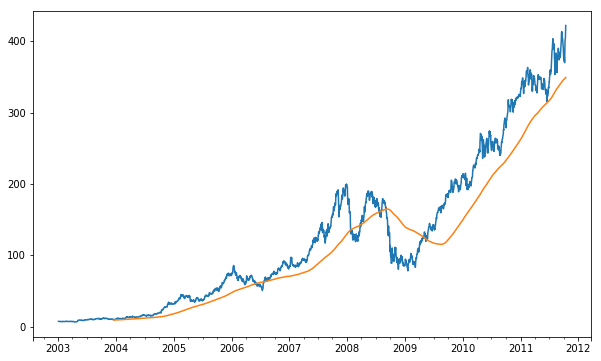

<Figure size 720x432 with 0 Axes>

In [182]:
close_px.AAPL.plot()
close_px.AAPL.rolling(250).mean().plot()
plt.figure()

表达式rolling(250)与groupby很像，但不是对其进⾏分组、创建
⼀个按照250天分组的滑动窗⼝对象。然后，我们就得到了苹果
公司股价的250天的移动窗⼝。
默认情况下，诸如rolling_mean这样的函数需要指定数量的⾮NA
观测值。可以修改该⾏为以解决缺失数据的问题。其实，在时间
序列开始处尚不⾜窗⼝期的那些数据就是个特例（⻅图11-5）：

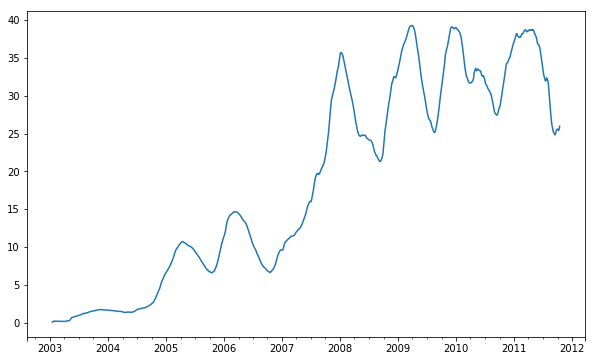

In [183]:
appl_std250 = close_px.AAPL.rolling(250, min_periods=10).std()
appl_std250[5:12]
appl_std250.plot()

要计算扩展窗⼝平均（expanding window mean），可以使⽤
expanding⽽不是rolling。 “扩展”意味着，从时间序列的起始处开
始窗⼝，增加窗⼝直到它超过所有的序列。 apple_std250时间序
列的扩展窗⼝平均如下所示：

In [184]:
expanding_mean = appl_std250.expanding().mean()

对DataFrame调⽤rolling_mean（以及与之类似的函数）会将转
换应⽤到所有的列上（⻅图11-6）：

In [185]:
plt.figure()

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

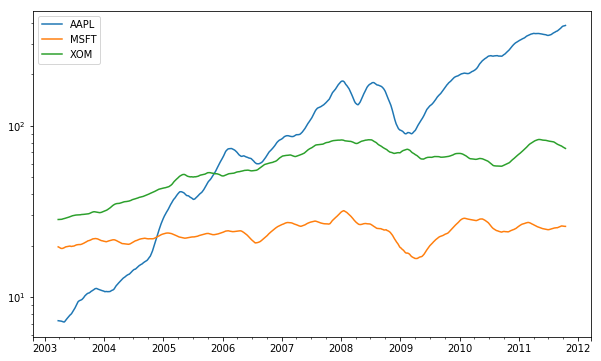

In [186]:
close_px.rolling(60).mean().plot(logy=True)

rolling函数也可以接受⼀个指定固定⼤⼩时间补偿字符串，⽽不
是⼀组时期。这样可以⽅便处理不规律的时间序列。这些字符串
也可以传递给resample。例如，我们可以计算20天的滚动均值，
如下所示：

In [187]:
close_px.rolling('20D').mean()

,AAPL,MSFT,XOM
2003-01-02,7.400000,21.110000,29.220000
2003-01-03,7.425000,21.125000,29.230000
2003-01-06,7.433333,21.256667,29.473333
2003-01-07,7.432500,21.425000,29.342500
2003-01-08,7.402000,21.402000,29.240000
2003-01-09,7.391667,21.490000,29.273333
2003-01-10,7.387143,21.558571,29.238571
2003-01-13,7.378750,21.633750,29.197500
2003-01-14,7.370000,21.717778,29.194444
2003-01-15,7.355000,21.757000,29.152000


###  指数加权函数Exponentially Weighted Functions

另⼀种使⽤固定⼤⼩窗⼝及相等权数观测值的办法是，定义⼀个
衰减因⼦（decay factor）常量，以便使近期的观测值拥有更⼤
的权数。衰减因⼦的定义⽅式有很多，⽐较流⾏的是使⽤时间间
隔（span），它可以使结果兼容于窗⼝⼤⼩等于时间间隔的简单
移动窗⼝（simple moving window）函数。
由于指数加权统计会赋予近期的观测值更⼤的权数，因此相对于
等权统计，它能“适应”更快的变化。
除了rolling和expanding， pandas还有ewm运算符。下⾯这个例
⼦对⽐了苹果公司股价的60⽇移动平均和span=60的指数加权移
动平均（如图11-7所示）：

In [188]:
plt.figure()

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

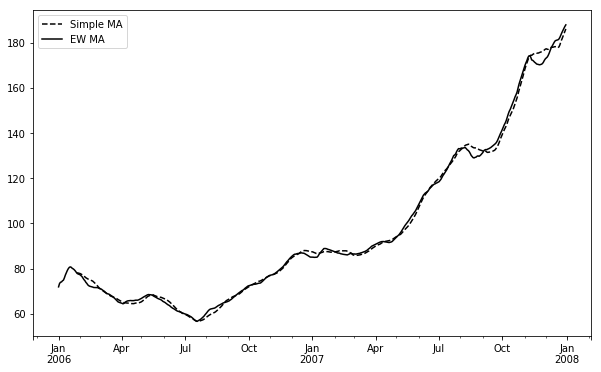

In [189]:
aapl_px = close_px.AAPL['2006':'2007']
ma60 = aapl_px.rolling(30, min_periods=20).mean()
ewma60 = aapl_px.ewm(span=30).mean()
ma60.plot(style='k--', label='Simple MA')
ewma60.plot(style='k-', label='EW MA')
plt.legend()

### ⼆元移动窗⼝函数Binary Moving Window Functions

In [190]:
plt.figure()

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

有些统计运算（如相关系数和协⽅差）需要在两个时间序列上执
⾏。例如，⾦融分析师常常对某只股票对某个参考指数（如标准
普尔500指数）的相关系数感兴趣。要进⾏说明，我们先计算我
们感兴趣的时间序列的百分数变化：

In [191]:
spx_px = close_px_all['SPX']
spx_rets = spx_px.pct_change()
returns = close_px.pct_change()

调⽤rolling之后， corr聚合函数开始计算与spx_rets滚动相关系数

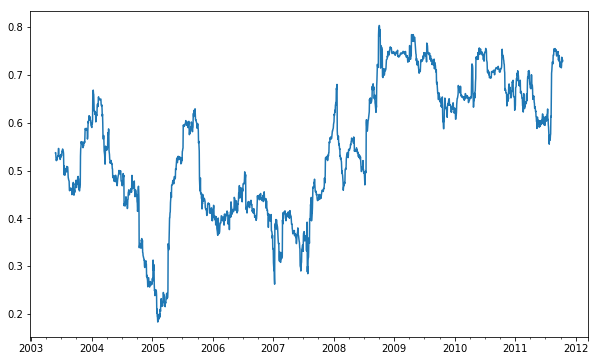

In [194]:
corr = returns.AAPL.rolling(125, min_periods=100).corr(spx_rets)
corr.plot()

假设你想要⼀次性计算多只股票与标准普尔500指数的相关系
数。虽然编写⼀个循环并新建⼀个DataFrame不是什么难事，但
⽐较啰嗦。其实，只需传⼊⼀个TimeSeries和⼀个DataFrame，
rolling_corr就会⾃动计算TimeSeries（本例中就是spx_rets）与
DataFrame各列的相关系数。结果如图11-9所示：

In [195]:
plt.figure()

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

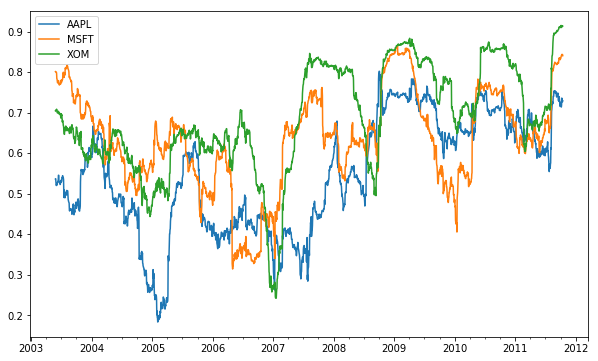

In [196]:
corr = returns.rolling(125, min_periods=100).corr(spx_rets)
corr.plot()

### ⽤户定义的移动窗⼝函数 User-Defined Moving Window Functions

rolling_apply函数使你能够在移动窗⼝上应⽤⾃⼰设计的数组函
数。唯⼀要求的就是：该函数要能从数组的各个⽚段中产⽣单个
值（即约简）。⽐如说，当我们⽤rolling(...).quantile(q)计算样本
分位数时，可能对样本中特定值的百分等级感兴趣。
scipy.stats.percentileofscore函数就能达到这个⽬的

In [197]:
plt.figure()

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

c:\users\xiaomi\anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  app.launch_new_instance()


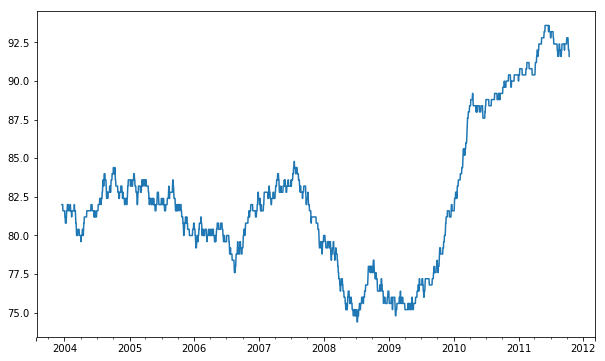

In [198]:
from scipy.stats import percentileofscore
score_at_2percent = lambda x: percentileofscore(x, 0.02)
result = returns.AAPL.rolling(250).apply(score_at_2percent)
result.plot()

In [199]:
pd.options.display.max_rows = PREVIOUS_MAX_ROWS

##  11.8 总结 Conclusion

与前⾯章节接触的数据相⽐，时间序列数据要求不同类型的分析
和数据转换⼯具。
在接下来的章节中，我们将学习⼀些⾼级的pandas⽅法和如何
开始使⽤建模库statsmodels和scikit-lear